In [1]:
# Standard Libraries
import re
import time
import string
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set(style="white")

# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model Evaluation & Utilities
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils import resample, class_weight
from sklearn.utils.class_weight import compute_class_weight

# Scikit-learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset

# Transformers (Hugging Face)
from transformers import (
    DistilBertTokenizer, DistilBertTokenizerFast, DistilBertModel,
    DistilBertForSequenceClassification, BertTokenizer, BertModel,
    Trainer, TrainingArguments, AutoTokenizer, AutoModel
)

# Sentence Transformers
from sentence_transformers import SentenceTransformer

# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from keras.losses import CategoricalFocalCrossentropy, SparseCategoricalCrossentropy
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import ReLU


c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install wordcloud
#!pip install nltk
#!pip install strings
#!pip install transformers
#!pip install torch
#!pip install -U sentence-transformers

In [3]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

<a class="anchor" id="chapter2"></a>

# 2. Data Exploration

</a>

- The only values in label are 0,1 and 2
- There are no missing values on both datasets;
- There are no duplicates on both datasets;

In [4]:
# Check the test set
print(df_test.shape)
df_test.head()

(2388, 2)


,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [6]:
# Set id as index
df_test.set_index('id', inplace=True)

In [7]:
# Check the train set
print(df_train.shape)
df_train.head()

(9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [8]:
# Check null values
print(f"Null values in labels = {df_train['label'].isna().sum()}")
print(f"Null values in text = {df_train['text'].isna().sum()}")

Null values in labels = 0
Null values in text = 0


In [9]:
# Check for missing values
print("Missing values in train dataset:")
print(df_train.isnull().sum())
print("\nMissing values in test dataset:")
print(df_test.isnull().sum())

Missing values in train dataset:
text     0
label    0
dtype: int64

Missing values in test dataset:
text    0
dtype: int64


In [10]:
# Check for duplicates
print("Duplicates in train dataset:", df_train.duplicated().sum())
print("Duplicates in test dataset:", df_test.duplicated().sum())

Duplicates in train dataset: 0
Duplicates in test dataset: 0


<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Labels

</a>

The average sentiment label in the training dataset is ~1.50, which suggests a **slight tendency toward positive or neutral sentiment**. Since the labels are categorical — Bearish (0), Bullish (1), and Neutral (2) — this average doesn’t map to a real sentiment but indicates that Bearish tweets are less frequent compared to Bullish and Neutral ones

In [11]:
label_counts = df_train['label'].value_counts().sort_index()
label_percent = round(df_train['label'].value_counts(normalize=True) * 100,1)

In [12]:
# get value counts for label
print("Label distribution in train dataset:")
print(label_counts)

# get value counts for label in percentage
print("Label distribution in train dataset (percentage):")
print(label_percent)

Label distribution in train dataset:
label
0    1442
1    1923
2    6178
Name: count, dtype: int64
Label distribution in train dataset (percentage):
label
2    64.7
1    20.2
0    15.1
Name: proportion, dtype: float64


In [13]:
# Check that labels are only 0,1, or 2
df_train['label'].unique()

array([0, 1, 2], dtype=int64)

In [14]:
print(f'Unique labels: {df_train["label"].unique()}')
df_train["label"].describe()

Unique labels: [0 1 2]


count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

In [15]:
# Get the label mean
label_mean = df_train['label'].mean()
print(f'Our training set has a mean of {round(label_mean,1)}')

Our training set has a mean of 1.5


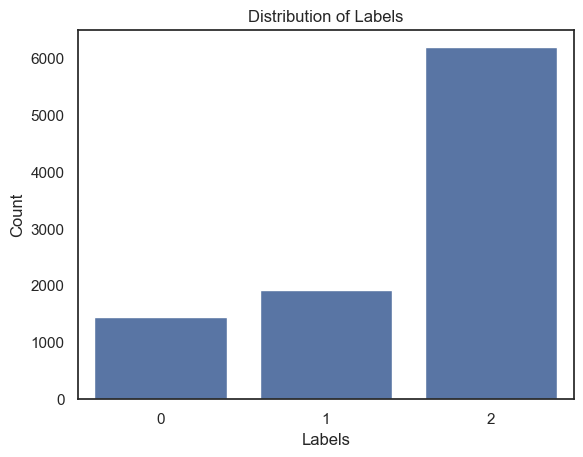

In [16]:
# Visualize distribution of labels
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

<Axes: ylabel='label'>

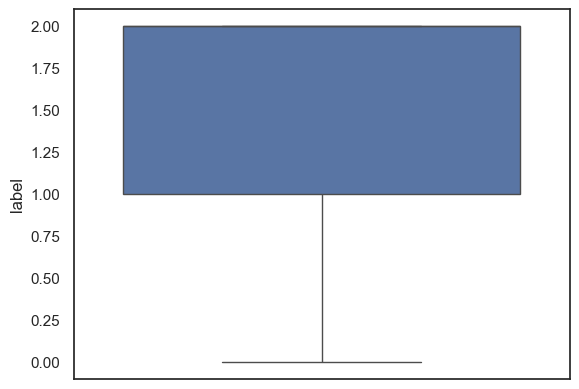

In [17]:
sns.boxplot(data=df_train['label'])

<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Text

</a>

`Key Findings` <br>

The average tweet length in the dataset is approximately 86 characters and 12 words.

Most tweets are fairly short, with 75% under 120 characters and under 15 words.

The shortest tweet has just 2 characters, and the longest reaches 190 characters or 32 words.

This confirms that the dataset fits the typical tweet format and is well-suited for models like RNNs, LSTMs, or Transformers that handle short text.

These findings will also help in setting padding/truncation parameters during preprocessing (e.g., max_len = 32 or max_len = 40 to be safe).

In [18]:
# Fetch wordcount and character count for each abstract
df_train['word_count'] = df_train['text'].str.split().apply(len)
df_train['char_count'] = df_train['text'].str.len()

df_train[['text','word_count', 'char_count']].head()

,text,word_count,char_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10,77
1,$CCL $RCL - Nomura points to bookings weakness...,14,102
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14,94
3,$ESS: BTIG Research cuts to Neutral https://t....,7,59
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10,71


In [19]:
df_train[['char_count', 'word_count']].describe()

,char_count,word_count
count,9543.000000,9543.000000
mean,85.858325,12.178351
std,35.138568,4.665599
min,2.000000,1.000000
25%,58.000000,9.000000
50%,79.000000,11.000000
75%,120.000000,15.000000
max,190.000000,32.000000


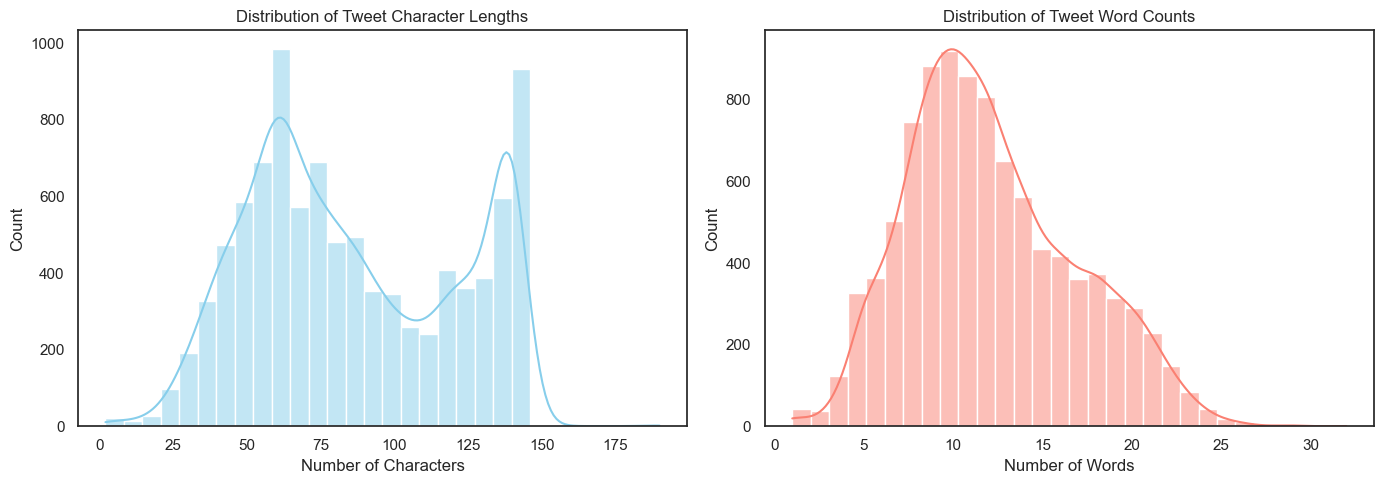

In [20]:
# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count
sns.histplot(df_train['char_count'], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Tweet Character Lengths')
axes[0].set_xlabel('Number of Characters')

# Word count
sns.histplot(df_train['word_count'], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Distribution of Tweet Word Counts')
axes[1].set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

In [21]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

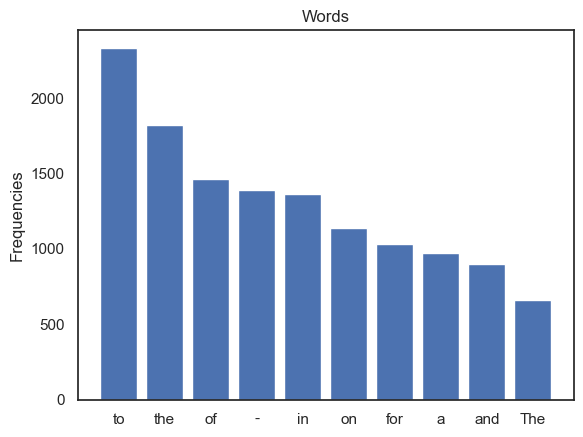

In [22]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()

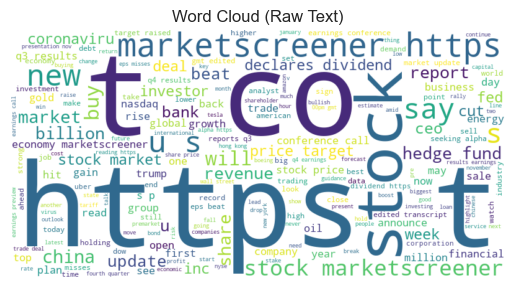

In [23]:
# Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Multivariate Analysis

</a>

<a class="anchor" id="sub-section-2_3_1"></a>

### 2.3.1. Word Count & Labels

</a>

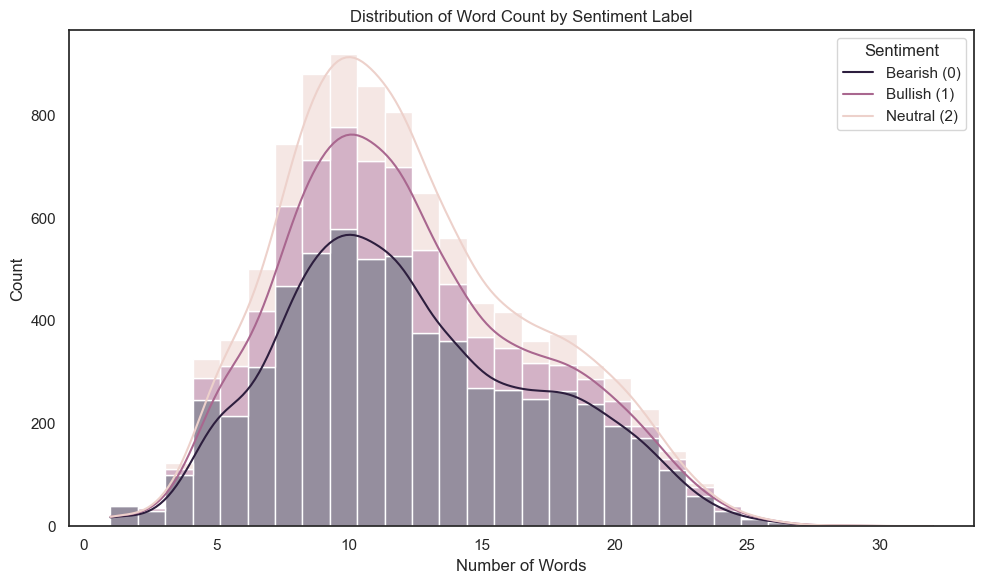

In [24]:
# Histogram of word count by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Word Count by Sentiment Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

All three distributions follow a roughly normal shape, suggesting that most tweets have a moderate word count, centered around 10–15 words. The overall count of the Neutral distribution appears higher, suggesting that the Neutral class might be more frequent in the dataset.

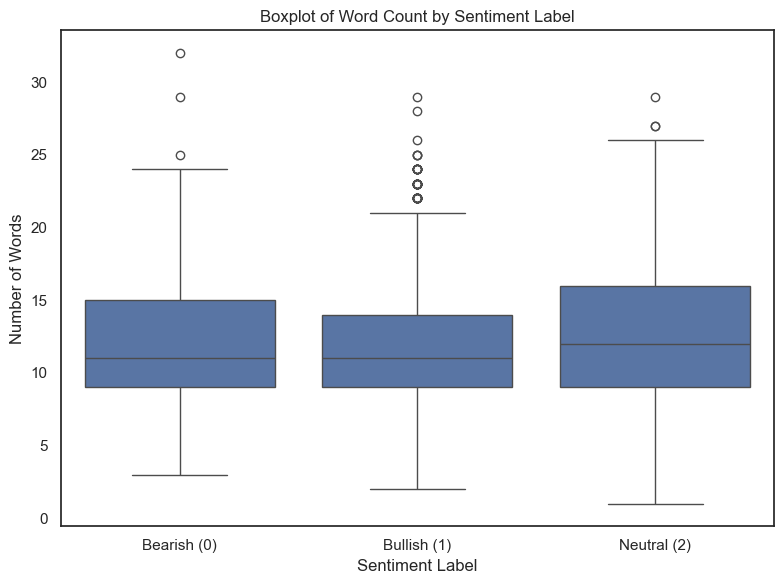

In [25]:
# Boxplot of word count by label
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='word_count')
plt.title('Boxplot of Word Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [26]:
# Get most frequent words
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return dict(most_common)

In [27]:
# Plot word cloud for a specific label
def plot_top_words_bar(df, label, label_name):
    texts = df[df['label'] == label]['text']
    top_words = get_top_n_words(texts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title(f'Top Words for {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

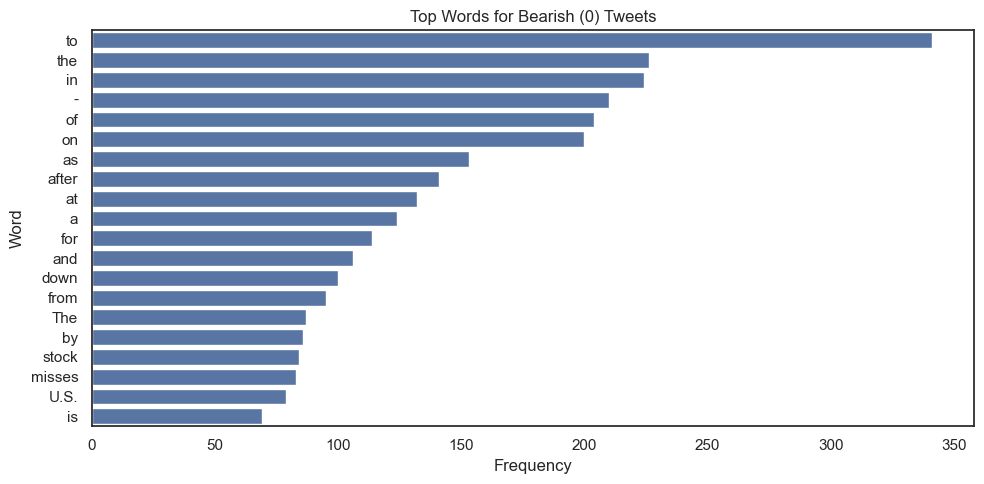

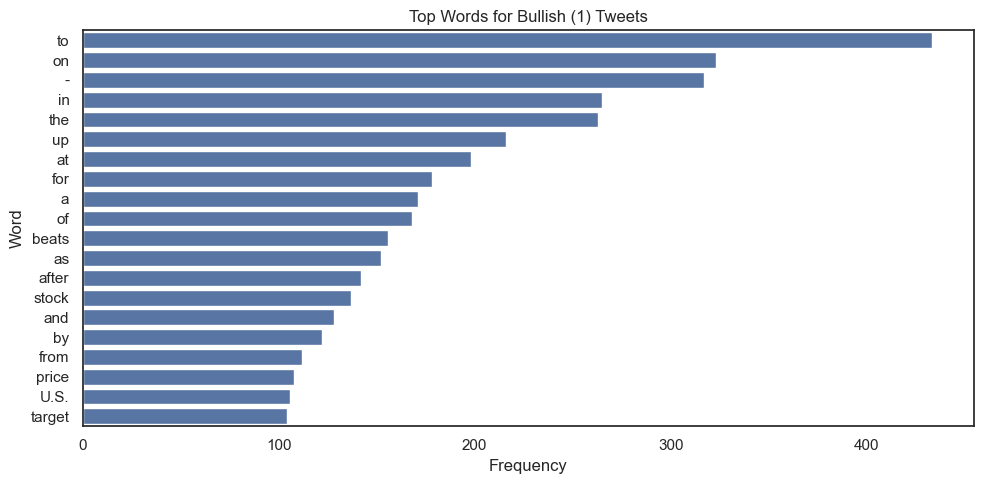

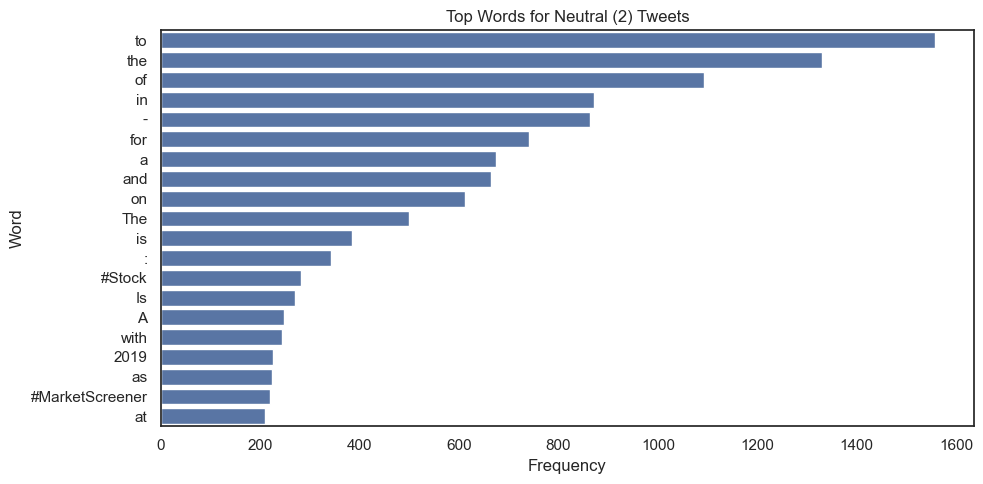

In [28]:
plot_top_words_bar(df_train, 0, 'Bearish (0)')
plot_top_words_bar(df_train, 1, 'Bullish (1)')
plot_top_words_bar(df_train, 2, 'Neutral (2)')

In [29]:
# Plot word cloud for each label
def plot_wordcloud(df, label, label_name):
    texts = df[df['label'] == label]['text']
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label_name} Tweets', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

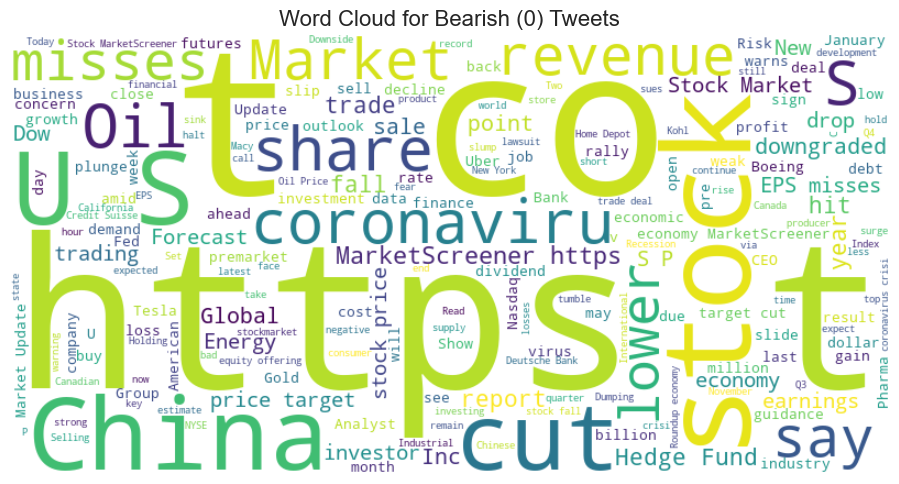

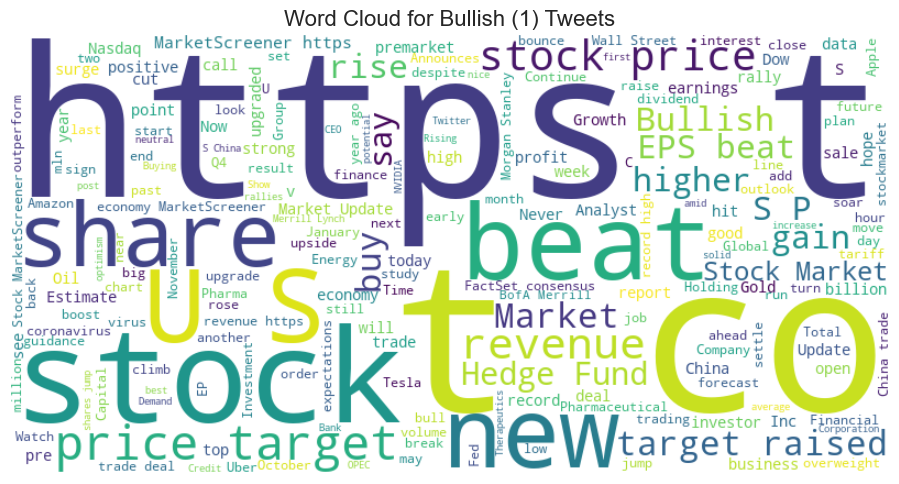

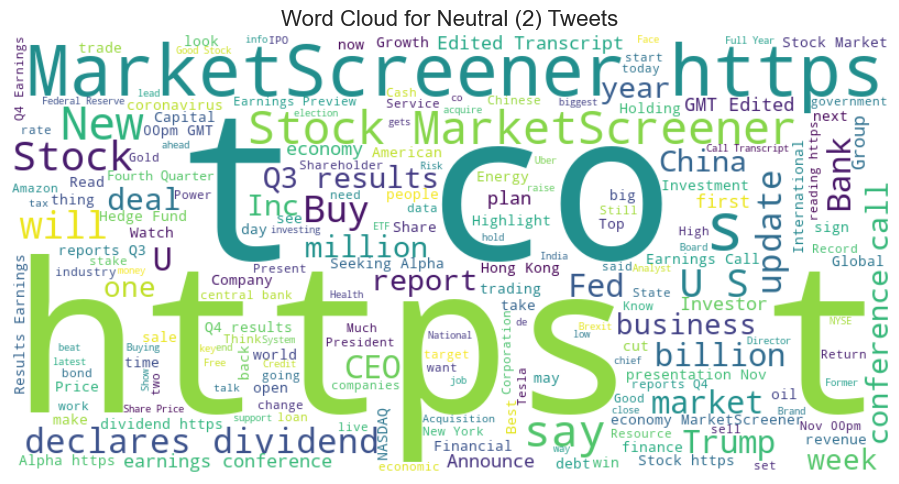

In [30]:
plot_wordcloud(df_train, 0, 'Bearish (0)')
plot_wordcloud(df_train, 1, 'Bullish (1)')
plot_wordcloud(df_train, 2, 'Neutral (2)')

`What the Word Clouds Reveal:` <br>

- Bearish Tweets often contain negatively charged words such as **cut, misses, lower, decline, and crisis-related terms like coronavirus, oil, and China**. This suggests a focus on economic threats, losses, and negative forecasts.

- Bullish Tweets are characterized by positive performance indicators such as **beat, rise, gain, target raised, and higher**. Words like buy and soar indicate strong investor confidence.

- Neutral Tweets tend to include objective and informative language, e.g., **update, conference call, results, CEO, dividend, MarketScreener**. These tweets appear more factual and less emotionally driven.


> The repeated appearance of noise tokens like **https, co, and rt** in all classes confirms the need for text cleaning before model training.

<a class="anchor" id="sub-section-2_3_2"></a>

### 2.3.2. Character Count & Labels

</a>

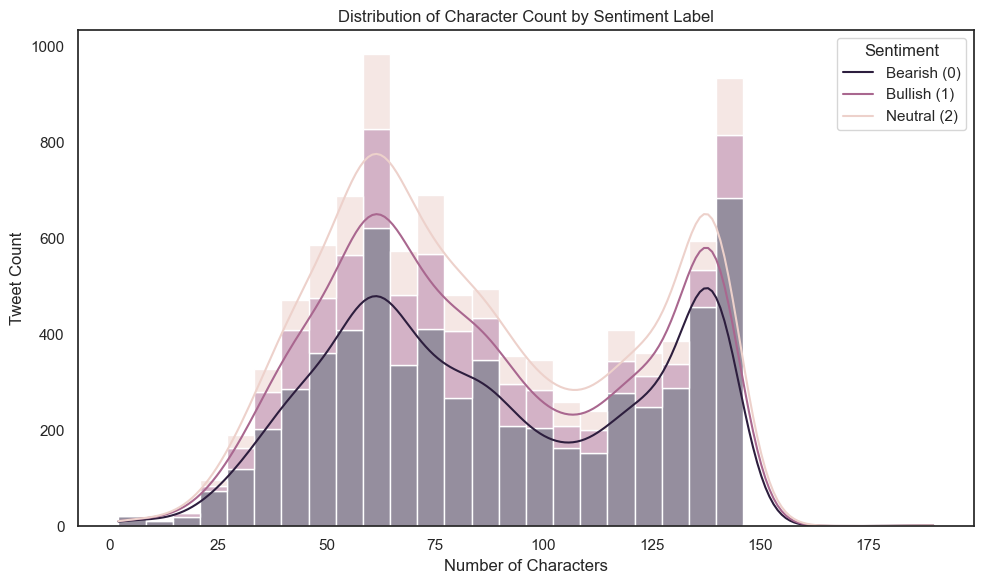

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Character Count by Sentiment Label')
plt.xlabel('Number of Characters')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

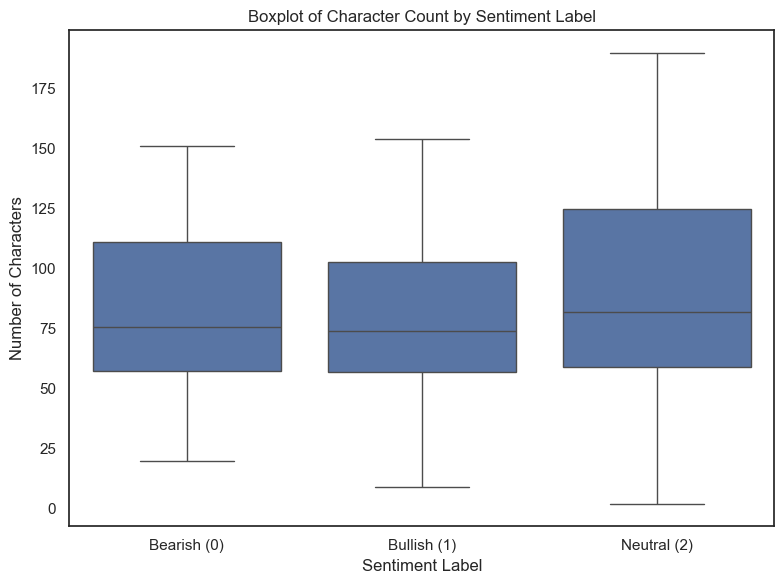

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='char_count')
plt.title('Boxplot of Character Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

<a class="anchor" id="sub-section-2_3_1"></a>

### 2.3.1. N-grams & Labels

</a>

By extracting the most frequent bigrams (2-word sequences) in the dataset, we identify recurring phrase patterns that reflect both the contextual structure of financial tweets and potential informative features for classification.

**A large portion of frequent bigrams are news-source references**, such as:

marketscreener https; <br>
stock marketscreener;<br>
economy marketscreener;<br>
stock https.

These likely come from automatic link-sharing tweets or syndicated content.

**Other bigrams are domain-specific and sentiment-relevant**, such as:

hedge funds;<br>
price target;<br>
stock market;<br>
stock price<br>
q3 results;<br>
earnings conference;

which are informative but likely neutral in tone.

In [33]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df_train['text'])
sum_words = X.sum(axis=0)

# Most common bigrams
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]

for word, freq in words_freq:
    print(f"{word}: {freq}")

marketscreener https: 478
stock marketscreener: 315
hedge funds: 163
price target: 141
stock market: 137
economy marketscreener: 137
stock price: 109
q3 results: 99
earnings conference: 90
stock https: 89


In [34]:
# Function to get top n-grams from the corpus
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=['ngram', 'count'])

In [35]:
# Function to plot top n-grams
def plot_top_ngrams(df, label, label_name, ngram_range=(2,2), top_n=20):
    texts = df[df['label'] == label]['text'].str.lower()
    top_ngrams = get_top_ngrams(texts, ngram_range=ngram_range, n=top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=top_ngrams)
    title_type = 'Bigrams' if ngram_range == (2,2) else 'Trigrams'
    plt.title(f'Top {title_type} in {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel(title_type)
    plt.tight_layout()
    plt.show()

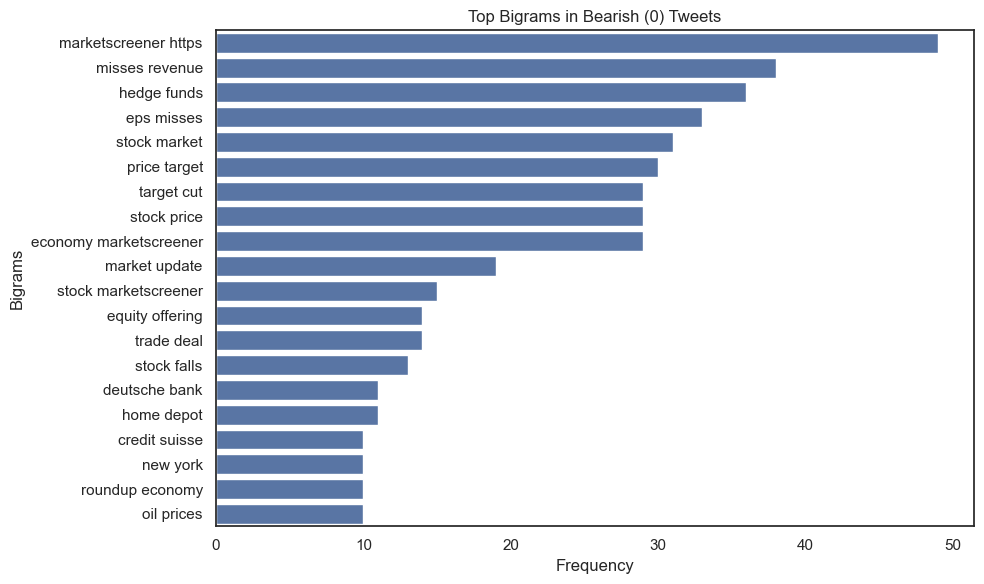

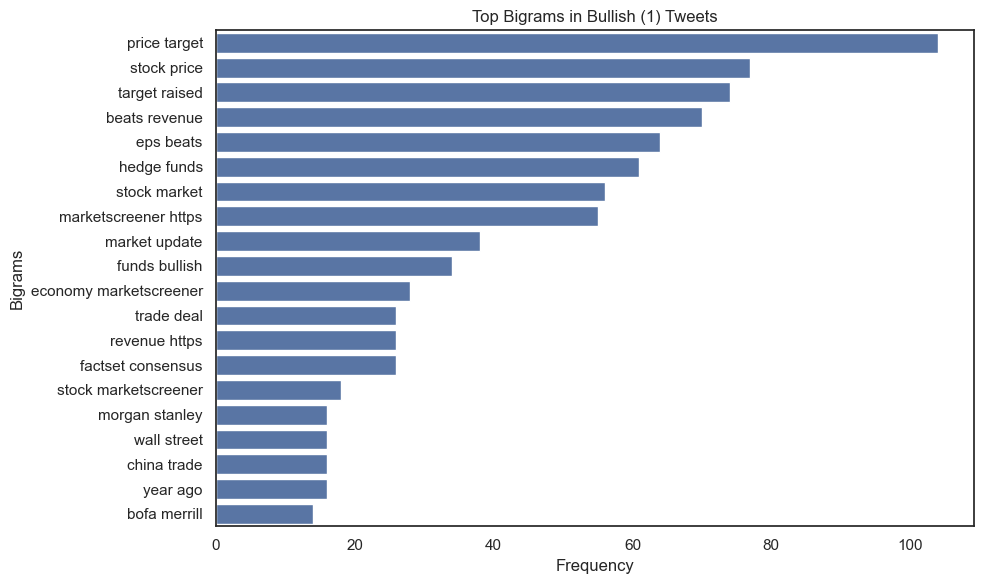

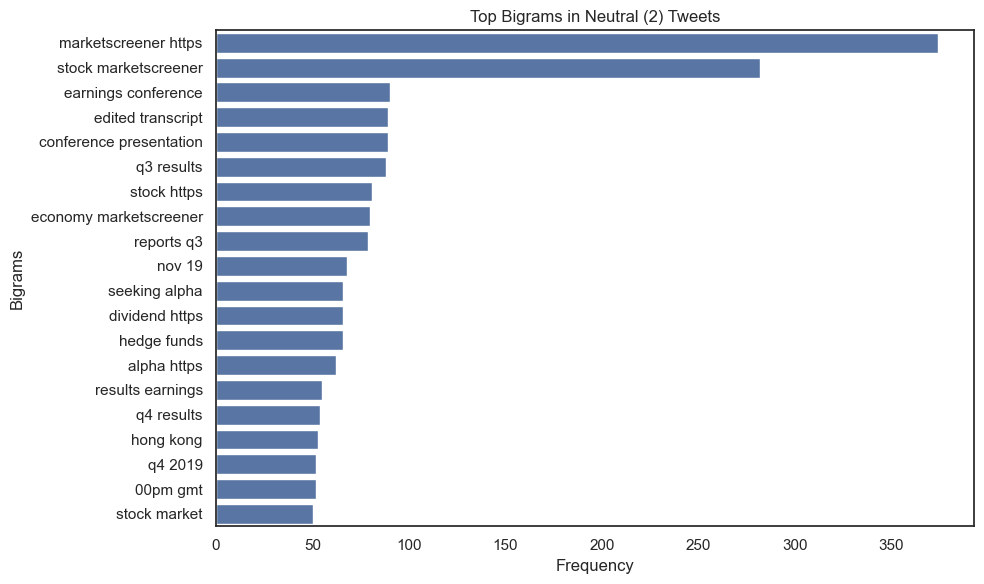

In [36]:
# Bigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(2,2))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(2,2))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(2,2))

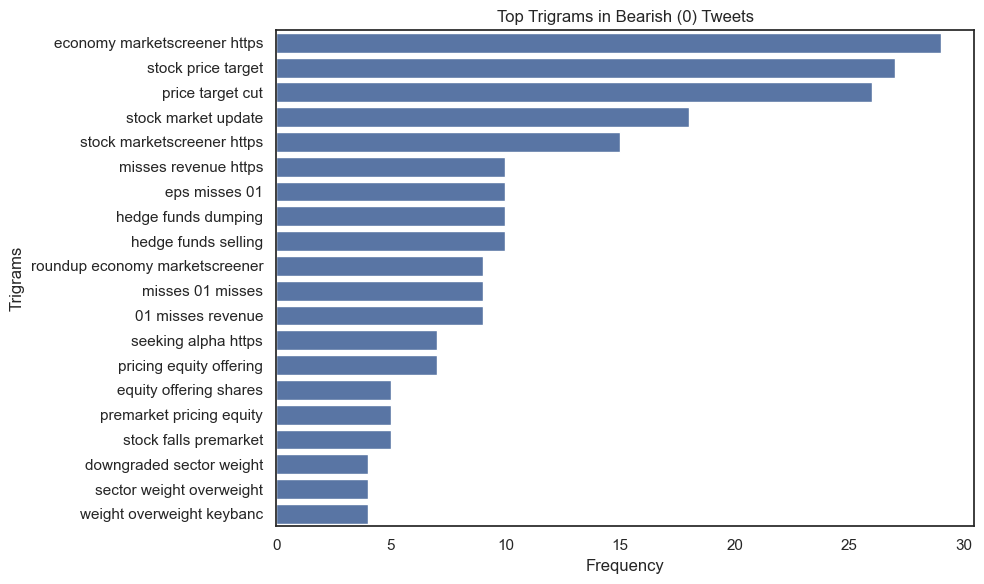

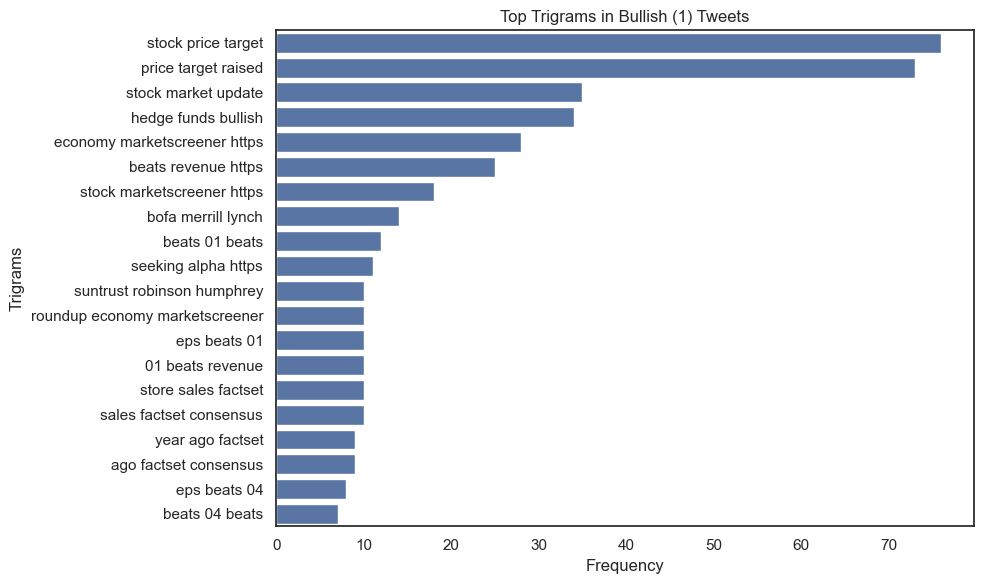

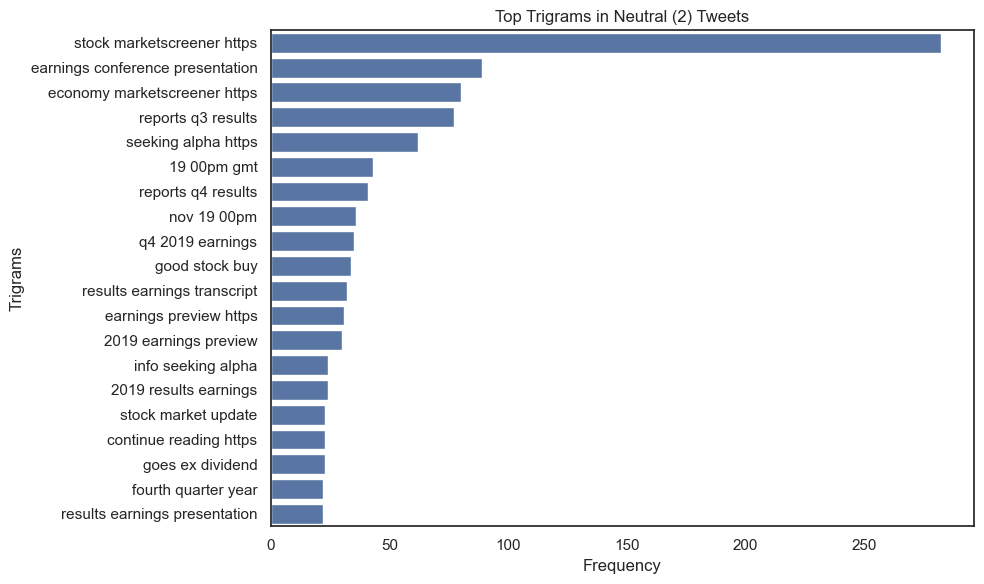

In [37]:
# Trigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(3,3))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(3,3))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(3,3))

<a class="anchor" id="chapter3"></a>

# 3. Data Split

</a>

To prepare the dataset for model training and validation, we performed an 80/20 split on the labeled data. This means that **80% of the tweets were used for training, while 20% were held out for validation purposes**. <br>
**The split was done using stratified sampling** to ensure that the distribution of sentiment labels (Bearish, Bullish, and Neutral) remained consistent across both sets. This is **important for preventing class imbalance issues** during training and evaluation. <br>
We did not create a separate test set since a dedicated, unlabeled test dataset was already provided as part of the project. 

In [38]:
train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)

# Check class distribution
print("Training Set:\n", train_df['label'].value_counts(normalize=True))
print("\nValidation Set:\n", val_df['label'].value_counts(normalize=True))

Training Set:
 label
2    0.647367
1    0.201467
0    0.151166
Name: proportion, dtype: float64

Validation Set:
 label
2    0.647459
1    0.201676
0    0.150864
Name: proportion, dtype: float64


In [39]:
len(train_df), len(val_df)

(7634, 1909)

<a class="anchor" id="chapter4"></a>

# 4. Data Preprocessing

</a>

To prepare the tweets for modeling, we applied a series of text preprocessing steps aligned with the theoretical guidelines from the course. The goal was to clean and normalize the text while retaining meaningful linguistic content for feature extraction.

The following techniques were applied:

`Lowercasing`  All text was converted to lowercase to ensure uniformity (e.g., “Stock” and “stock” are treated the same).

`Noise Removal` We removed URLs, mentions, hashtags, and retweet markers (RT) using regular expressions, as these tokens do not contribute to sentiment analysis.

`Punctuation and Digit Removal` All punctuation symbols and numeric characters were stripped to reduce sparsity and dimensionality.

`Tokenization` We used NLTK’s TreebankWordTokenizer, a rule-based tokenizer that works efficiently without external dependencies like punkt.

`Stopword Removal and Lemmatization` We filtered out common English stopwords (e.g., "and", "the", "of") and lemmatized each remaining token to reduce inflectional variations (e.g., “running” → “run”).

These steps produced a clean and compact representation of the original tweets, ready for downstream tasks like vectorization and sentiment classification.

In [40]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [41]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

In [42]:
# Preprocessing function
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Regex Cleaning
    text = re.sub(r"http\S+|www\S+", '', text)                         # Remove URLs
    text = re.sub(r"@\w+|#\w+|rt", '', text)                           # Remove mentions, hashtags, RT
    text = re.sub(r"br", "", text)                                     # Remove 'br' (e.g. <br> tags)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)      # Remove punctuation
    text = re.sub(r"[^a-zA-Z\s]", ' ', text)                           # Remove numbers and special characters
    text = re.sub(r"\s+", " ", text).strip()                           # Remove extra whitespace

    # 3. Tokenize using Treebank tokenizer
    tokens = tokenizer.tokenize(text)

    # 4. Remove stopwords and short tokens, then lemmatize
    clean_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]

    return " ".join(clean_tokens)

In [43]:
# Apply function to train and validation datasets
train_df['clean_text'] = train_df['text'].fillna('').apply(preprocess_text)
val_df['clean_text']   = val_df['text'].fillna('').apply(preprocess_text)
df_test['clean_text']  = df_test['text'].fillna('').apply(preprocess_text)


In [44]:
# Check before and after cleaning
print("Original tweet:\n", train_df['text'].iloc[6])
print("Cleaned tweet:\n", train_df['clean_text'].iloc[6])

Original tweet:
 Could Applied DNA Sciences, Inc. (APDN) See a Reversal After Breaking Its 52 Week Low? - The Lamp News
Cleaned tweet:
 could applied dna science inc apdn see reversal eaking week low lamp news


<a class="anchor" id="chapter5"></a>

# 5. Feature Engineering

</a>

In [45]:
X_train_cleaned = train_df['clean_text']
X_val_cleaned = val_df['clean_text']
X_test_cleaned = df_test['clean_text']

<a class="anchor" id="sub-section-5_1"></a>

## 5.1. BoW

</a>

In [46]:
def extract_bow_features(train_texts, val_texts):
    vectorizer = CountVectorizer(binary=True)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    return X_train, X_val, vectorizer

In [47]:
# Apply BoW to training and validation sets
bow_X_train, bow_X_val, bow_vectorizer = extract_bow_features(X_train_cleaned, X_val_cleaned)

In [48]:
term_counts = np.array(bow_X_train.sum(axis=0)).flatten()
terms = bow_vectorizer.get_feature_names_out()
top_terms_df = pd.DataFrame({'term': terms, 'count': term_counts}).sort_values(by='count', ascending=False)

In [49]:
top_terms_df.head(10)

,term,count
10325,stock,656
6507,market,346
8481,price,315
7244,new,310
9484,say,307
9123,result,304
9735,share,273
3326,earnings,273
5294,inc,246
4345,fund,239


<a class="anchor" id="sub-section-5_2"></a>

## 5.2. TF-IDF

</a>

In [50]:
def extract_tfidf_features(train_texts, val_texts):
    vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1,1))
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_val = vectorizer.transform(val_texts).toarray()
    return X_train, X_val, vectorizer

In [51]:
tfidf_X_train, tfidf_X_val, tfidf_vectorizer = extract_tfidf_features(X_train_cleaned, X_val_cleaned)   # the test is missing here

In [52]:
# View top 10 IDF values
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
list(idf_dict.items())[4100:4110]

[('firstquaer', 9.247351037092788),
 ('firsttime', 8.554203856532842),
 ('fiscal', 6.721622392784532),
 ('fisher', 9.247351037092788),
 ('fit', 8.841885928984624),
 ('fitbit', 9.247351037092788),
 ('fitful', 9.247351037092788),
 ('fitness', 8.331060305218632),
 ('fittest', 9.247351037092788),
 ('fitzgerald', 9.247351037092788)]

In [53]:
# Embedding for the lstm model


<a class="anchor" id="sub-section-5_3"></a>

## 5.3. Word2Vec

</a>

In [54]:
def get_average_word2vec(texts, model):
    features = []
    for text in texts:
        words = text.split()
        valid_words = [model.wv[word] for word in words if word in model.wv]
        if valid_words:
            avg = np.mean(valid_words, axis=0)
        else:
            avg = np.zeros(model.vector_size)
        features.append(avg)
    return np.array(features)

In [55]:
tokenized_train = [text.split() for text in X_train_cleaned]
tokenized_val = [text.split() for text in X_val_cleaned]

In [56]:
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1)

In [57]:
word2vec_X_train = get_average_word2vec(X_train_cleaned, w2v_model)
word2vec_X_val = get_average_word2vec(X_val_cleaned, w2v_model)
word2vec_X_test = get_average_word2vec(X_test_cleaned, w2v_model)

Word2Vec Embedding Preparation for LSTM

In this step, we:

1. Convert cleaned text into sequences of word indices.
2. Pad these sequences to a fixed length for batch processing.
3. Create an embedding matrix using Word2Vec vectors, mapping each word index to a pretrained dense vector.

This allows the LSTM model to process uniform-length input while leveraging semantic word relationships learned from Word2Vec.


In [58]:

# Tokenizing the cleaned training text into sequences of word indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_cleaned)

# Converting training and test texts into sequences of word indices
X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_val_seq = tokenizer.texts_to_sequences(X_val_cleaned)
X_test_seq = tokenizer.texts_to_sequences(X_test_cleaned)


# Pad sequences to ensure all have the same length
MAXLEN = 100  # Max number of tokens per sentence
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAXLEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post')

import numpy as np

# Creating the embedding matrix using the pre-trained Word2Vec model
word_index = tokenizer.word_index  # Dictionary mapping words to their index
vocab_size = len(word_index) + 1  # +1 for padding token
embedding_dim = w2v_model.vector_size  # Dimension of Word2Vec embeddings


# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]


# Filling embedding matrix, each row i corresponds to the Word2Vec vector of the word with index i
for word, idx in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]   # Assign vector if word exists in Word2Vec vocab

<a class="anchor" id="sub-section-5_4"></a>

## 5.4. Distil BERT

</a>

Here, **we used BERT-based sentence embeddings via the DistilBERT model from Hugging Face**. Unlike traditional methods like TF-IDF, **BERT captures contextual relationships between words, which is particularly useful for short, informal text like tweets**. <br>
We applied DistilBERT’s tokenizer to each tweet, padded and truncated the sequences to a fixed length, and passed them through the pretrained encoder. From the output, we extracted the embedding of the [CLS] token, which serves as a summary representation of the entire tweet. This process produced a 768-dimensional vector for each tweet in both the training and validation sets. <br>
These dense embeddings will be used as input features for our classifier, allowing it to leverage semantic information and improve sentiment prediction performance.

In [59]:
# Load pretrained DistilBERT model and tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
# Disable dropout
bert_model.eval()

# CLS embeddings for classification tasks
def transformer_cls_embeddings(texts, batch_size=32):
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = bert_tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            out = bert_model(**enc)
        # out.last_hidden_state: (batch, seq_len, hidden_dim)
        cls_embs = out.last_hidden_state[:, 0, :]  # First token is [CLS]
        all_embs.append(cls_embs.cpu().numpy())
    return np.vstack(all_embs)

# Embed the training and test sets
X_train_transformer = transformer_cls_embeddings(X_train_cleaned.tolist())
X_val_transformer  = transformer_cls_embeddings(X_val_cleaned.tolist())
X_test_cleaned = transformer_cls_embeddings(X_test_cleaned.tolist())

Transformer Token-Level Embeddings for LSTM

Here, we use a pretrained DistilBERT model to generate token-level embeddings for each text:

1. Each sentence is tokenized and padded to a fixed length.
2. The model outputs a sequence of hidden states (one per token).
3. These token embeddings are extracted and stored as input features.

This creates a 3D tensor (samples × max_length × 768), suitable for feeding into an LSTM that learns from contextualized token representations.


In [ ]:
def transformer_token_embeddings(texts, batch_size=16, max_length=32):
    all_seqs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = bert_tokenizer(
            batch,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        with torch.no_grad():
            out = bert_model(**enc)
        last_hidden = out.last_hidden_state  # shape: (batch, max_length, 768)
        all_seqs.append(last_hidden.cpu().numpy())
    return np.concatenate(all_seqs, axis=0)

# Embed the training and test sets
X_train_bert_seq = transformer_token_embeddings(X_train_cleaned.tolist())
#X_test_bert_seq  = transformer_token_embeddings(X_test_cleaned.tolist())
X_val_bert_seq = transformer_token_embeddings(X_val_cleaned.tolist())

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=64)
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(X_train_cleaned, y_train)
test_dataset = TweetDataset(X_test_cleaned, y_test)
val_dataset = TweetDataset(X_val_cleaned, y_val)

TypeError: 'Tokenizer' object is not callable

Dataset Preparation for Transformer Fine-Tuning

We define a custom PyTorch `Dataset` to wrap the text and labels:

1. Texts are tokenized using the DistilBERT tokenizer with padding and truncation.
2. Labels are converted to tensors for supervised training.
3. The dataset returns tokenized inputs and corresponding labels for each sample.

This format is required for fine-tuning the DistilBERT model using Hugging Face’s `Trainer` API.


<a class="anchor" id="sub-section-5_6"></a>

## 5.6. Sentence-Transformer (SBERT) for Financial Sentences

</a>

Sentence-Transformer (SBERT) for Financial Sentences

https://huggingface.co/ohsuz/k-finance-sentence-transformer

In [ ]:
# Load the finance-tuned SBERT
sbert = SentenceTransformer("ohsuz/k-finance-sentence-transformer")

# Encode
sbert_X_train = sbert.encode(X_train_cleaned.tolist(), show_progress_bar=True)
sbert_X_val  = sbert.encode(X_val_cleaned.tolist(),  show_progress_bar=True)
sbert_X_test = sbert.encode(X_test_cleaned.tolist(), show_progress_bar=True)

Batches: 100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


TypeError: object of type 'float' has no len()

<a class="anchor" id="chapter6"></a>

# 6. Models

</a>

<a class="anchor" id="sub-section-6_1"></a>

## 6.1. Functions for Evaluation

</a>

In [ ]:
# Prepare data and get y (labels)
y_train = train_df['label']
y_val = val_df['label']

In [ ]:
# For individual evaluation
def evaluate_classification(feature_used, y_true, y_pred):
    print("Evaluation metrics with", feature_used, "features.")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

In [ ]:
# For comparing results across models and representations

# Starting with the table structure
results_columns = [
    "Model", "Representation",
    # Train Metrics 
    "Train_Prec", "Train_Rec", "Train_F1",
    # Val Metrics
    "Val_Prec",   "Val_Rec",   "Val_F1",
]
results = pd.DataFrame(columns=results_columns)

# log_result unpacks both overall and per-label metrics
def log_result(
    # Defining the class of each each parameter    
    model_name: str,
    feat_name: str,
    # overall
    train_prec: float, train_rec: float, train_f1: float,
    # validation overall
    val_prec: float,   val_rec: float,   val_f1: float,
):
    global results
    row = {
        "Model": model_name,
        "Representation": feat_name,
        # Overall Train
        "Train_Prec": train_prec,
        "Train_Rec":  train_rec,
        "Train_F1":   train_f1,
        # Overall Val 
        "Val_Prec":   val_prec,
        "Val_Rec":    val_rec,
        "Val_F1":     val_f1
    }
    results.loc[len(results)] = row


def evaluate_and_log(
    model_name, feat_name, model, X_tr, y_tr, X_te, y_te
):
    # Predictions
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    # If output is probabilities (LSTM, softmax, etc), convert to class labels
    if len(y_tr_pred.shape) > 1 and y_tr_pred.shape[1] > 1:
        y_tr_pred = y_tr_pred.argmax(axis=1)
        y_te_pred = y_te_pred.argmax(axis=1)

    # Train Metrics 
    tr_prec = precision_score(y_tr, y_tr_pred, average="macro")
    tr_rec  = recall_score(   y_tr, y_tr_pred, average="macro")
    tr_f1   = f1_score(       y_tr, y_tr_pred, average="macro")

    # Val Metrics 
    val_prec = precision_score(y_te, y_te_pred, average="macro")
    val_rec  = recall_score(   y_te, y_te_pred, average="macro")
    val_f1   = f1_score(       y_te, y_te_pred, average="macro")
    
    # Log Everything into the results table 
    log_result(
        model_name=model_name,
        feat_name=feat_name,
        train_prec=tr_prec,
        train_rec=tr_rec,
        train_f1=tr_f1,
        val_prec=val_prec,
        val_rec=val_rec,
        val_f1=val_f1
    )

# show() to display the results table
def show():
    print(results.to_string(index=False))

<a class="anchor" id="sub-section-6_2"></a>

## 6.2. KNN

</a>

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

<a class="anchor" id="sub-section-6_2_1"></a>

### 6.2.1. WITH BOW

</a>

In [ ]:

knn.fit(bow_X_train, y_train)
knn_bow_pred = knn.predict(bow_X_val)

In [ ]:
evaluate_classification("BoW", y_val, knn_bow_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7008905185961236
Precision (macro): 0.6831263076597635
Recall (macro): 0.45235912056300404
F1 Score (macro): 0.46991597110124744

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6197    0.1528    0.2451       288
           1     0.7273    0.2286    0.3478       385
           2     0.7024    0.9757    0.8168      1236

    accuracy                         0.7009      1909
   macro avg     0.6831    0.4524    0.4699      1909
weighted avg     0.6949    0.7009    0.6360      1909



In [ ]:
evaluate_and_log(
    model_name="KNN",
    feat_name="BoW",
    model=knn,
    X_tr=bow_X_train,
    y_tr=y_train,
    X_te=bow_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_2_2"></a>

### 6.2.2. WITH TF-IDF

</a>

In [ ]:
knn.fit(tfidf_X_train, y_train)
knn_tfidf_pred = knn.predict(tfidf_X_val)

In [ ]:
evaluate_classification("TF-IDF", y_val, knn_tfidf_pred)

Evaluation metrics with TF-IDF features.
Accuracy: 0.679413305395495
Precision (macro): 0.6806979859571323
Recall (macro): 0.4009081219032675
F1 Score (macro): 0.39125538280616007

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.5366    0.0764    0.1337       288
           1     0.8281    0.1377    0.2361       385
           2     0.6774    0.9887    0.8039      1236

    accuracy                         0.6794      1909
   macro avg     0.6807    0.4009    0.3913      1909
weighted avg     0.6865    0.6794    0.5883      1909



In [ ]:
evaluate_and_log(
    model_name="KNN",
    feat_name="TF-IDF",
    model=knn,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_2_3"></a>

### 6.2.3. WITH WORD2VEC

</a>

In [ ]:
knn.fit(word2vec_X_train, y_train)
knn_word2vec_pred = knn.predict(word2vec_X_val)

In [ ]:
evaluate_classification("Word2Vec", y_val, knn_word2vec_pred)

Evaluation metrics with Word2Vec features.
Accuracy: 0.6003143006809848
Precision (macro): 0.42668506171987614
Recall (macro): 0.4143027010745457
F1 Score (macro): 0.41733583672313523

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.1834    0.1458    0.1625       288
           1     0.3787    0.2961    0.3324       385
           2     0.7179    0.8010    0.7572      1236

    accuracy                         0.6003      1909
   macro avg     0.4267    0.4143    0.4173      1909
weighted avg     0.5689    0.6003    0.5818      1909



In [ ]:
evaluate_and_log(
    model_name="KNN",
    feat_name="Word2Vec",
    model=knn,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_2_4"></a>

### 6.2.4. WITH DISTIL BERT

</a>

In [ ]:
knn.fit(X_train_transformer, y_train)
knn_dbert_pred = knn.predict(X_val_transformer)

In [ ]:
evaluate_classification("Distil BERT",y_val, knn_dbert_pred)

Evaluation metrics with Distil BERT features.


ValueError: Found input variables with inconsistent numbers of samples: [1909, 2388]

<a class="anchor" id="sub-section-6_2_5"></a>

### 6.2.5. WITH SENTENCE BERT

</a>

In [ ]:
knn.fit(sbert_X_train, y_train)
knn_sbert_pred = knn.predict(sbert_X_val)

In [ ]:
evaluate_classification("Sentence-BERT", y_val, knn_sbert_pred)

In [ ]:
evaluate_and_log(
    model_name="KNN",
    feat_name="Sentence BERT",
    model=knn,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_val,
    y_te=y_val
)

### 6.2.6. Fine-tuning the best combination

In [ ]:
# Feature and label
X = X_train_transformer
y = y_train

# Define parameter grid for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

In [ ]:

# Training
knn_grid.fit(X, y)

# Best model, parameters and score
best_knn = knn_grid.best_estimator_
print("Best params:", knn_grid.best_params_)
print("Best CV F1 macro score:", knn_grid.best_score_)

# Predict on test
y_pred = best_knn.predict(X_test_transformer)


In [ ]:
# Storing the results
evaluate_classification("Transformer BERT CV", y_val, y_pred)

evaluate_and_log(
    model_name="KNN CV-GS",
    feat_name="Transformer BERT",
    model=best_knn,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_test_transformer,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_2"></a>

## 6.3. Logistic Regression

</a>

In [ ]:
clf = LogisticRegression(max_iter=1000, random_state=42)

<a class="anchor" id="sub-section-6_3_1"></a>

### 6.3.1. WITH BOW

</a>

In [ ]:
clf.fit(bow_X_train, y_train)
clf_bow_pred = clf.predict(bow_X_val)

In [ ]:
evaluate_classification("BoW", y_val, clf_bow_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7888947092718701
Precision (macro): 0.7509790118387301
Recall (macro): 0.6520884994185965
F1 Score (macro): 0.6874656064651626

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6911    0.4583    0.5511       288
           1     0.7526    0.5610    0.6429       385
           2     0.8092    0.9369    0.8684      1236

    accuracy                         0.7889      1909
   macro avg     0.7510    0.6521    0.6875      1909
weighted avg     0.7800    0.7889    0.7750      1909



In [ ]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="BoW",
    model=clf,
    X_tr=bow_X_train,
    y_tr=y_train,
    X_te=bow_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_3_2"></a>

### 6.3.2. WITH TF-IDF

</a>

In [ ]:
clf.fit(tfidf_X_train, y_train)
clf_tfidf_pred = clf.predict(tfidf_X_val)

In [ ]:
evaluate_classification("BoW", y_val, clf_tfidf_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7684651650078576
Precision (macro): 0.7653564730463723
Recall (macro): 0.5941138149876014
F1 Score (macro): 0.638318134054717

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.7742    0.3333    0.4660       288
           1     0.7510    0.4935    0.5956       385
           2     0.7709    0.9555    0.8533      1236

    accuracy                         0.7685      1909
   macro avg     0.7654    0.5941    0.6383      1909
weighted avg     0.7674    0.7685    0.7429      1909



In [ ]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="TF-IDF",
    model=clf,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_3_3"></a>

### 6.3.3. WITH WORD2VEC

</a>

In [ ]:
clf.fit(word2vec_X_train, y_train)
clf_word2vec_pred = clf.predict(word2vec_X_val)

In [ ]:
evaluate_classification("BoW", y_val, clf_word2vec_pred)

Evaluation metrics with BoW features.
Accuracy: 0.6516500785751702
Precision (macro): 0.3678979041294874
Recall (macro): 0.3563548102383054
F1 Score (macro): 0.3131705918078143

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       288
           1     0.4430    0.0909    0.1509       385
           2     0.6607    0.9782    0.7886      1236

    accuracy                         0.6517      1909
   macro avg     0.3679    0.3564    0.3132      1909
weighted avg     0.5171    0.6517    0.5410      1909



/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applicati

In [ ]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Word2Vec",
    model=clf,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_3_4"></a>

### 6.3.4. WITH DISTIL BERT

</a>

In [ ]:
clf.fit(distilbert_X_train, y_train)
clf_dbert_pred = clf.predict(distilbert_X_val)

In [ ]:
print("Validation Set Results:\n")
print(classification_report(y_val, clf_dbert_pred, target_names=["Bearish", "Bullish", "Neutral"]))

<a class="anchor" id="sub-section-6_3_5"></a>

### 6.3.5. WITH SENTENCE BERT

</a>

In [ ]:
clf.fit(sbert_X_train, y_train)
clf_sbert_pred = clf.predict(sbert_X_val)

In [ ]:
evaluate_classification("SentenceBert", y_val, clf_sbert_pred)

In [ ]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Sequence BERT",
    model=clf,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_val,
    y_te=y_val
)

### 6.3.6. Fine-tunning the best model

In [ ]:
X = BoW_X_train  
y = y_train

# Hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],       
    'penalty': ['l2'],                    
    'solver': ['liblinear', 'saga'],    
    'max_iter': [500, 1000]
}

# Stratified K-Fold to preserve label distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=LogisticRegression(n_jobs=-1, random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',   
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)


In [ ]:
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV F1 Macro Score:", grid_search.best_score_)

In [ ]:
y_pred = best_model.predict(BoW_X_test)
#print(classification_report(y_val y_pred))

evaluate_classification("BoW/Lg-CV", y_val y_pred)

evaluate_and_log(
    model_name="Logistic Regression CV-GS",
    feat_name="BoW",
    model=best_model,
    X_tr=X,
    y_tr=y,
    X_te=BoW_X_test,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_4"></a>

## 6.4. Basic Multi-Layer Perceptron (MLP)

</a>

We trained a Multi-Layer Perceptron (MLP) using the BERT-based embeddings from the training set and evaluated its performance on the validation set. With a maximum of 1000 iterations and early stopping enabled, the model converged after 27 epochs and achieved an overall accuracy of 74%. It maintained strong performance on Neutral tweets (F1-score of 0.84), while Bearish and Bullish classes remained more challenging, with F1-scores of 0.44 and 0.53 respectively. These results indicate that the MLP captured some non-linear patterns in the data, but performance on the minority classes was still limited, likely due to class imbalance and overlapping sentiment cues. Further improvements may require rebalancing the training data or switching to a more flexible modeling framework like PyTorch.

In [ ]:
# Initialize MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=1000,          
    random_state=42,
    early_stopping=True,
    verbose=True
)

<a class="anchor" id="sub-section-6_4_1"></a>

### 6.4.1. WITH BOW

</a>

In [ ]:
mlp.fit(bow_X_train, y_train)
mlp_bow_pred = mlp.predict(bow_X_val)

In [ ]:
evaluate_classification("BoW/Mlp", y_val, mlp_bow_pred)

In [ ]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="BoW",
    model=mlp,
    X_tr=bow_X_train,
    y_tr=y_train,
    X_te=bow_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_4_2"></a>

### 6.4.2. WITH TF-IDF

</a>

In [ ]:
mlp.fit(tfidf_X_train, y_train)
mlp_tfdif_pred = mlp.predict(tfidf_X_val)

In [ ]:
evaluate_classification("TF-IDF/Mlp", y_val, mlp_tfdif_pred)

In [ ]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="TF-IDF",
    model=mlp,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_4_4"></a>

### 6.4.4. WITH WORD2VEC

</a>

In [ ]:
mlp.fit(word2vec_X_train, y_train)
mlp_word2vec_pred = mlp.predict(word2vec_X_val)

In [ ]:
evaluate_classification("Word2Vec/Mlp", y_val, mlp_word2vec_pred)

In [ ]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="Word2Vec",
    model=mlp,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_val,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_4_4"></a>

### 6.4.4. WITH DISTIL BERT

</a>

In [ ]:
# Train on training set
mlp.fit(X_train_transformer, y_train)

In [ ]:
val_preds = mlp.predict(X_test_transformer)
print("Validation Set Results:\n")
print(classification_report(y_val, val_preds, target_names=["Bearish", "Bullish", "Neutral"]))

<a class="anchor" id="sub-section-6_4_5"></a>

### 6.4.5. WITH SENTENCE BERT

</a>

In [ ]:
mlp.fit(sbert_X_train, y_train)
mlp_sbert_pred = mlp.predict(sbert_X_val)

In [ ]:
evaluate_classification("Sentence Bert", y_val, mlp_sbert_pred)

In [ ]:
evaluate_and_log(
    model_name="Mlp",
    feat_name="Sequence BERT",
    model=mlp,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_val,
    y_te=y_val
)

### 6.4.6. Fine-tunning best model

In [ ]:
# Define TF-IDF as input
X = tfidf_X_train
y = y_train

# Define search space
param_grid = {
    'hidden_layer_sizes': [(256, 128),(128, 128),(256, 128, 64)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200],
    'early_stopping': [True]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mlp_grid = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

In [ ]:
mlp_grid.fit(X, y)


best_mlp_tfidf = mlp_grid.best_estimator_

print("Best params:", mlp_grid.best_params_)
print("Best CV F1 macro score:", mlp_grid.best_score_)


In [ ]:
# Predict on test
y_pred = best_mlp_tfidf.predict(tfidf_X_test)

evaluate_classification("TF-IDF/MLP CV", y_val y_pred)

evaluate_and_log(
    model_name="MLP CV-GS",
    feat_name="TF-IDF",
    model=best_mlp_tfidf,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_test,
    y_te=y_val
)

<a class="anchor" id="sub-section-6_5"></a>

## 6.5. LSTM

</a>

The first step to train the LSTM with Word2Vec is to adapt the original approach. Initially, we averaged the Word2Vec vectors for each sentence, which removed word order and produced fixed-size feature vectors. While this is fine for traditional ML models, it’s not suitable for LSTMs, which require sequential input.

To make Word2Vec compatible with LSTM, we:

- Tokenize the text into sequences of word indices using Keras' Tokenizer

- Pad the sequences to a fixed length to ensure uniform input shape

- Build an Embedding layer using the pre-trained Word2Vec vectors (embedding matrix)

- Feed the padded sequences into the Embedding + LSTM layers

This adaptation preserves the order of words and allows the LSTM to learn from the sequential structure of the text

In [ ]:
num_classes = 3 

from sklearn.utils import class_weight
 
# adding class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

from keras.losses import CategoricalFocalCrossentropy
from keras.utils import to_categorical

# Converting labels to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=3)
y_valcat = to_categorical(y_val num_classes=3)

6.5.1 With Word2vec

In [ ]:
def build_lstm(input_length, vocab_size, embedding_dim, embedding_matrix, num_classes=3, dropout=0.3, l2_reg=0.001):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=input_length,
        trainable=True
    ))

    # First Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    # Second LSTM layer (optional)
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(dropout))

    # Dense stack
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_lstm(
    input_length=MAXLEN,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    num_classes=3,
    dropout=0.3,
    l2_reg=0.001
)

In [ ]:
model.compile(
    loss=CategoricalFocalCrossentropy(gamma=2.0,alpha=[2.5, 2.0, 1.0]), # using focal loss, so we can handle class imbalance
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Callbacks for training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0
)


model.summary()

In [ ]:
# Training the model
model.fit(
    X_train_pad, y_train_cat,  
    validation_data=(X_test_pad, y_val_cat),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    #class_weight=class_weights,
    verbose=1
)


In [ ]:
y_pred_probs = model.predict(X_test_pad)
y_pred = y_pred_probs.argmax(axis=1)  # Convert back to class labels

In [ ]:
# Use original y_val(sparse)
evaluate_and_log("LSTM", "Word2vec", model, X_train_pad, y_train, X_test_pad, y_val

### 6.5.2. With BERT

In [ ]:
def build_lstm_bert(input_shape, num_classes=3, dropout=0.3, l2_reg=0.001):
    model = Sequential()

    # Input shape is (sequence_length, embedding_dim)
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(dropout))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    return model

SEQ_LEN = X_train_bert_seq.shape[1]     # should be max_length,
EMBED_DIM = X_train_bert_seq.shape[2]   # should be 768 for BERT-base


model_bert = build_lstm_bert(
    input_shape=(SEQ_LEN, EMBED_DIM),
    num_classes=3,
    dropout=0.3,
    l2_reg=0.001
)

In [ ]:
model_bert.compile(
    loss=CategoricalFocalCrossentropy(gamma=2.0, alpha=[2.5, 2.0, 1.0]),
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model_bert.fit(
    X_train_bert_seq, y_train_cat,
    validation_data=(X_test_bert_seq, y_valcat),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

In [ ]:
y_pred_probs = model_bert.predict(X_test_bert_seq)
y_pred = y_pred_probs.argmax(axis=1)

evaluate_and_log("LSTM", "Transformer BERT", model_bert, X_train_bert_seq, y_train, X_test_bert_seq, y_val)


### 6.5.3. With Sentence BERT

In [ ]:
# SBERT embeddings shape: [N, 768]
sbert_dim = sbert_X_train.shape[1]
SEQ_LEN = 12
EMBED_DIM = sbert_dim // SEQ_LEN  # 64 if 768

# Reshape SBERT vectors for LSTM
X_train_sbert_seq = sbert_X_train.reshape(-1, SEQ_LEN, EMBED_DIM)
X_test_sbert_seq = sbert_X_test.reshape(-1, SEQ_LEN, EMBED_DIM)

model_sbert = build_lstm_bert(  # same as with BERT
    input_shape=(SEQ_LEN, EMBED_DIM),
    num_classes=3,
    dropout=0.3,
    l2_reg=0.001
)

In [ ]:
model_sbert.compile(
    loss=CategoricalFocalCrossentropy(gamma=2.0, alpha=[2.5, 2.0, 1.0]),
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model_sbert.fit(
    X_train_sbert_seq, y_train_cat,
    validation_data=(X_test_sbert_seq, y_valcat),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


In [ ]:
y_pred_probs = model_sbert.predict(X_test_sbert_seq)
y_pred = y_pred_probs.argmax(axis=1)

evaluate_and_log("LSTM", "Sequence BERT", model_sbert, X_train_sbert_seq, y_train, X_test_sbert_seq, y_val


**to update**

**BERT/SBERT + LSTM Underperformed**

- Loss of sequential information: The BERT and SBERT embeddings used were averaged across the whole sentence. This removed the order of the words, which LSTMs rely on to learn patterns.

- LSTM not used effectively: Since the input to the LSTM was just a single vector per sentence (instead of a sequence of vectors), the LSTM couldn't model temporal or contextual dependencies between words.

- No fine-tuning: The embeddings came from a frozen, general-purpose model and were not adapted to your specific dataset, which can limit their usefulness for your classification task.

- Mismatch in architecture: Transformer-based embeddings already capture a lot of semantic meaning. Passing them through an LSTM on top especially without sequences doesn't add value and may introduce noise.

## 6.6. Transformer

In [ ]:
# 2. Wrap your data in a Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=64)
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(X_train_cleaned, y_train)
test_dataset = TweetDataset(X_test_cleaned, y_val

In [ ]:
# 3. Define metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro"),
    }


In [ ]:
raining_args = TrainingArguments(
    output_dir="./bert_output",            # Still required, but no files will be saved
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    save_strategy="no",                    # ← 🚫 disables saving checkpoints
    logging_strategy="no",                 # ← (optional) disables log writing
    report_to=[],                          # ← (optional) disables reporting to WandB, TensorBoard, etc.
)


In [ ]:
# 5. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 6. Train the model
trainer.train()


In [ ]:
# 7. Predict on both splits
train_preds = trainer.predict(train_dataset)
test_preds = trainer.predict(test_dataset)

y_train_pred = np.argmax(train_preds.predictions, axis=1)
y_val_pred = np.argmax(test_preds.predictions, axis=1)

# 8. Evaluate and log
tr_prec = precision_score(y_train, y_train_pred, average="macro")
tr_rec  = recall_score(   y_train, y_train_pred, average="macro")
tr_f1   = f1_score(       y_train, y_train_pred, average="macro")

val_prec = precision_score(y_val y_valpred, average="macro")
val_rec  = recall_score(   y_val y_val_pred, average="macro")
val_f1   = f1_score(       y_val, y_val_pred, average="macro")

log_result(
    model_name="Transformer",
    feat_name="Fine-tuned DistilBERT",
    train_prec=tr_prec, train_rec=tr_rec, train_f1=tr_f1,
    val_prec=val_prec, val_rec=val_rec, val_f1=val_f1
)

<a class="anchor" id="chapter7"></a>

# 7. Model & Representation Comparison

</a>

In [ ]:
show()

Questions for Ruben
- Diogo and Ruben both use Distil Bert -- are they the same?
- From experimental notebook, I copied Bert (but not the distil version) -- should we just use distil version, or both?
- What to do with Diogo's rest of his notebook?